In [1]:
from astropy.io import fits
from IPython.display import Image

%pylab
%matplotlib inline

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


This example notebook demonstrates how `pyTWR` radial modification of Tremaine-Weinderg method, introduced in https://arxiv.org/pdf/astro-ph/0511069.pdf, should be applied to real data.

In [3]:
import pytwr

# Data preparation

We will use the same CO data for **NGC 4826** from BIMA SONG survey https://ned.ipac.caltech.edu/level5/March02/SONG/SONG.html, as in the original paper.

We need FITS files for TWR: velocities map (moment 1) and surface densities (or intensities as equivalent, moment 0).

For correct estimation we also need to find in literature of measure information about positional angle (`PA`), distance to galaxy (`D`), size of pix in data in arcsec (`bima_scale`), galaxy center location on image and systemic velocity if moment 1 map not corrected for it. Additionally we also need to know inclination (`incl`) of the galaxy under consideration.

In [20]:
D = 4.1 # Mpc, thus dist_scale = 0.019877360925490 kpc/arcsec

bima_scale = 1. # arcsec/pix

pix_kpc = bima_scale*0.019877360925490 # kpc/pix

PA = 112. # deg

image_center = ( 180, 162) # image center in pix

incl = 60. # deg

v_syst = 408. # km/s, see Table 1 in arxiv.org/pdf/astro-ph/0304294.pdf

Load data and take a look at it:

In [14]:
fname = './NGC4826.bima12m.gmom1.fits'
mom1data = fits.getdata(fname)
mom1data[np.isnan(mom1data)] = 0.

fname = './NGC4826.bima12m.mmom0.fits'
mom0data = fits.getdata(fname)
mom0data[np.isnan(mom0data)] = 0.000000001
mom0data[mom0data < 0.] = 0.000000001

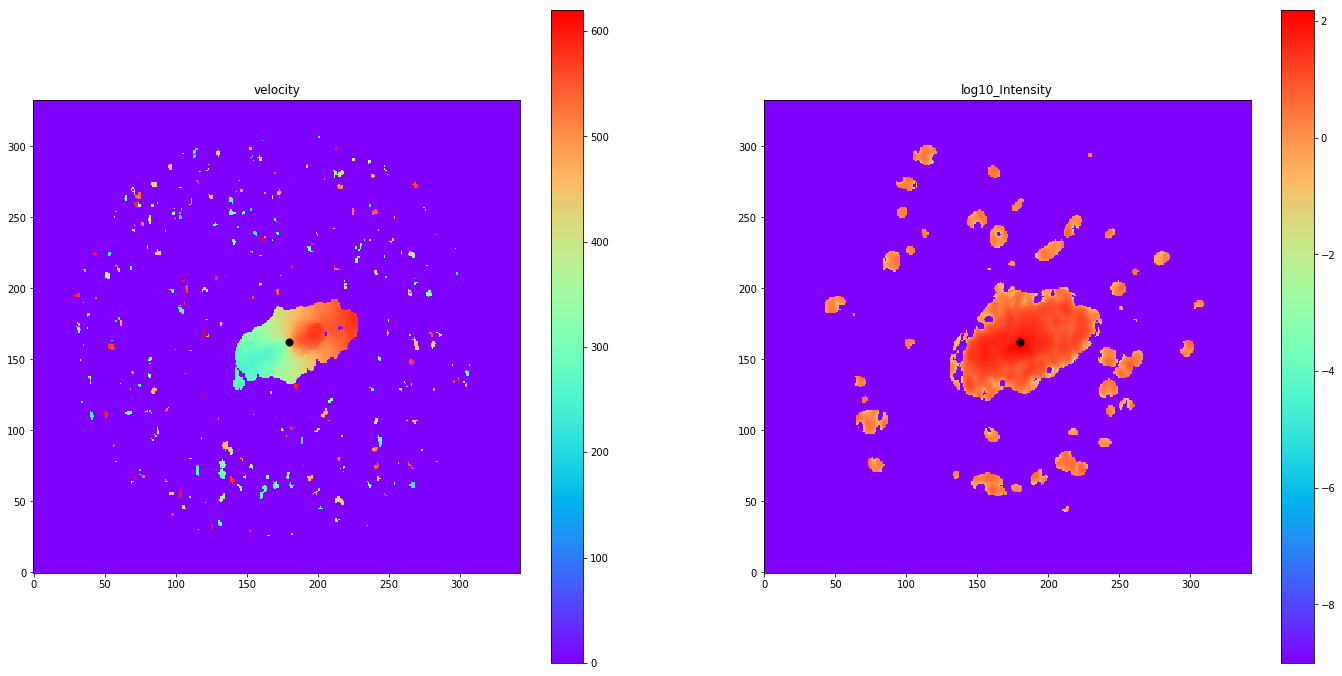

(1, 1, 333, 343)

In [21]:
fig = plt.figure(figsize=[24,12])
ax = plt.subplot(121)
im = ax.imshow(np.squeeze(mom1data), origin='lower', cmap='rainbow')
fig.colorbar(im, ax=ax)
ax.scatter(image_center[0], image_center[1], 50, 'k')
ax.set_title('velocity')

ax = plt.subplot(122)
im = plt.imshow(np.squeeze(np.log10(mom0data)), origin='lower', cmap='rainbow')
fig.colorbar(im, ax=ax)
ax.scatter(image_center[0], image_center[1], 50, 'k')
ax.set_title('log10_Intensity')

plt.show()
shape(mom0data)

Let's rotate both maps thus so major axis align parallel to X-axis. *Note that you sometimes you need to use 90+PA instead of PA, just keep an eye on resulted image.*

In [22]:
plane_v = np.zeros((343, 333))
plane_intens = np.zeros((343, 333))
plane_v = pytwr.rotate_image(mom1data[0,0,:,:], angle=112.+90., center=image_center)
plane_intens = pytwr.rotate_image(mom0data[0,0,:,:], angle=112.+90, center=image_center)

Subtract systemic velocity:

In [23]:
plane_v = plane_v - v_syst
plane_v[plane_v < -v_syst+0.001] = 0. # to keep all pixs with zero signal

/home/guzel/LALA/QQQ/my_env/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


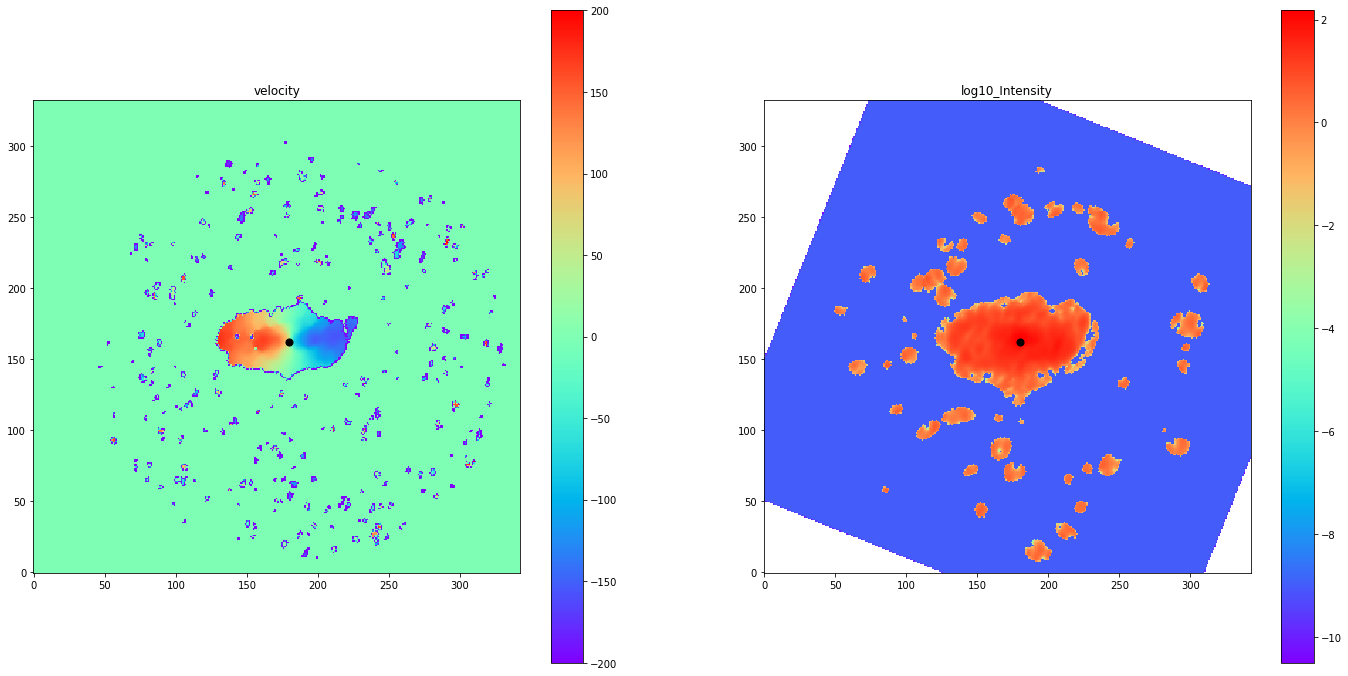

In [24]:
fig = plt.figure(figsize=[24,12])
ax = plt.subplot(121)
im = ax.imshow(np.squeeze(plane_v), origin='lower', cmap='rainbow', vmin=-200, vmax=200)
fig.colorbar(im, ax=ax)
ax.scatter(image_center[0], image_center[1], 50, 'k')
ax.set_title('velocity')

ax = plt.subplot(122)
im = plt.imshow(np.squeeze(np.log10(plane_intens)), origin='lower', cmap='rainbow')
fig.colorbar(im, ax=ax)
ax.scatter(image_center[0], image_center[1], 50, 'k')
ax.set_title('log10_Intensity')

plt.show()

Make sure that velocities on Y-axis are close to zero, which mean the PA rotation and systemic velocity are correct.

Data is ready now for pattern velocity search.

# Application of TWR

To find pattern speeds we need to select side of the galaxy we will use (y>0 or y<0) and solve Eq. (3) from https://arxiv.org/pdf/0711.4104.pdf numerically. To do so, we need to cut galaxy to ellipses (see Fig. 1 in the same page), choose limits of integration `X_lim` and solve triangular matrix equation.

How we cut to ellipses is an essential part, because this determines on which radii we will detect pattern speed $\Omega$ (and its variations). Usually it is natural to have cuts of the same width, so we need to choose `ymin` - offset from the galaxy's center in pix (or, in other words, where we start the first ellipse. This is needed if you want to avoid bar, etc.), `delta_y` - step between cuts and number of cuts `y_bins`. 

Let's illustrate this for y>0 side:

In [ ]:
ymin = 8.
y_bins = 3
delta_y = 5.
X_max = 100.
exitFlag=False
for y_bins in range (3,5):
    #exitFlag=False
    #omega, rrs = pytwr.solve_TWR(intens=plane_intens, vel=plane_v, 
      #              center=image_center, incl=incl,
       #             delta_y = delta_y, y_bins = y_bins, ymin=ymin, X_max = X_max, 
        #            verbose=False, 
         #           r_scale=pix_kpc, 
          #          lim_frame=True)
   # aa = np.array(omega.shape)
   # aa[:] = 0
   # bb = np.array(omega.shape)
   # bb[:] = 600
   # check = np.logical_and(omega>0.,omega<1000.)
   # if(np.all(check)):
   #     break   
    for delta_y in range (3,8):
        #exitFlag=False
        #omega, rrs = pytwr.solve_TWR(intens=plane_intens, vel=plane_v, 
        #                center=image_center, incl=incl,
        #                delta_y = delta_y, y_bins = y_bins, ymin=ymin, X_max = X_max, 
        #                verbose=False, 
        #                r_scale=pix_kpc, 
        #                lim_frame=True)
       # check = np.logical_and(omega>0.,omega<1000.)
       # if(np.all(check)):
       #     exitFlag=True
       #     break
                
        for ymin in range (4,17):
         #   exitFlag=False   
            omega, rrs = pytwr.solve_TWR(intens=plane_intens, vel=plane_v, 
                            center=image_center, incl=incl,
                            delta_y = delta_y, y_bins = y_bins, ymin=ymin, X_max = X_max, 
                            verbose=False, 
                            r_scale=pix_kpc, 
                            lim_frame=True)       
            check = np.logical_and(omega>0.,omega<1000.)
            if(np.all(check)):
                exitFlag=True
                break
                     
            #ymin +=1
        if(exitFlag):
            break    
       # delta_y +=1
    if(exitFlag):
        break 
   # y_bins +=1   
fig = plt.figure(figsize=[24,12])
ax = plt.subplot(121)
im = ax.imshow(np.squeeze(plane_v), origin='lower', cmap='rainbow', vmin=-200, vmax=200)
fig.colorbar(im, ax=ax)
ax.scatter(image_center[0], image_center[1], 50, 'k')
ax.set_title('velocity')

pytwr.overlay_ellipses_grid(ax, ymin=ymin, delta_y=delta_y, y_bins=y_bins, X_max=X_max, center=image_center, incl=incl)

ax = plt.subplot(122)
im = plt.imshow(np.squeeze(np.log10(plane_intens)), origin='lower', cmap='rainbow', vmin=-2)
fig.colorbar(im, ax=ax)
ax.scatter(image_center[0], image_center[1], 50, 'k')
ax.set_title('log10_Intensity')

pytwr.overlay_ellipses_grid(ax, ymin=ymin, delta_y=delta_y, y_bins=y_bins, X_max=X_max, center=image_center, incl=incl)

plt.show()

There are 3 radial bins, because the inner one is just offset and not included. Let's show how TWR can be applied for exactly the same set of parameters:

In [186]:
%%time
#omega, rrs = pytwr.solve_TWR(intens=plane_intens, vel=plane_v, 
                             center=image_center, incl=incl,
                             delta_y = delta_y, y_bins = y_bins, ymin=ymin, X_max = X_max, 
                             verbose=False, 
                             r_scale=pix_kpc, 
                             lim_frame=True)

CPU times: user 1min 30s, sys: 12.1 s, total: 1min 42s
Wall time: 1min 17s


Besides already known parameters there are three additional:

* `verbose` constrols if you want to see additional prints and pictures for better understanding and debugging (example below)
* `r_scale` is just a scale in kpc/pix to convert $\Omega$ to proper units
* `lim_frame` works for `verbose=True` only and regulate if we see the full image or just part of it

Returned values are list of pattern speeds in km/s/kpc and radial bins in pix:

In [13]:
omega, rrs

(array([ 1.41513225e+04, -1.91461158e+05, -4.98672993e+04,  2.54181707e+03,
         6.34699084e+01]),
 [19.532393420183297,
  28.077815541513488,
  36.62323766284368,
  45.168659784173876,
  53.71408190550407,
  62.25950402683426])

Let's plot them:

In [ ]:
print(ymin,
y_bins,delta_y,
X_max)
fig = plt.figure(figsize=[12,8])
ax = plt.gca()
tmp = []
for ind, om in enumerate(omega):
    tmp.append([rrs[ind]*bima_scale, om])
    tmp.append([rrs[ind+1]*bima_scale, om])
tmp = np.array(tmp)
ax.plot(tmp[:, 0], tmp[:, 1], '-s', color='k')
ax.grid()
plt.xlabel('R, arcsec')
plt.ylabel('Omega, km/s/kpc')
plt.show()

Thus we can conclude that for such parameters $\Omega$ is not constant and vary in the disk.

Let's run the same TWR with `verbose=True` to get many additional plots:

In [ ]:
omega, rrs = pytwr.solve_TWR(intens=plane_intens, vel=plane_v, 
                             center=image_center, incl=incl,
                             delta_y = delta_y, y_bins = y_bins, ymin=ymin, X_max = X_max, 
                             verbose=True, 
                             r_scale=pix_kpc, 
                             lim_frame=True)

We now see additional information, including matrix, right side of the equation, residuals of solution and many additional plots, which shows location of ellipses and integration limits on data maps, all slices on them and which part each segment adds in equation left and right side (all color-coded).

# Original TW method

We can also apply original T-W method for constant $\Omega$. Notation and logic are the same, but we can also explicitly state slice positions.

In [31]:
%%time
pytwr.solve_TW(intens=plane_intens,
              vel=plane_v,
              center=image_center,
              incl=incl,
              ys = [],
              delta_y=6.,
              y_bins=7,
              X_max=100.0,
              ymin=0.,
              verbose=False,
              r_scale=pix_kpc,
              ax=None,
              img_scale=1.5)

CPU times: user 1min 48s, sys: 16.7 s, total: 2min 4s
Wall time: 1min 36s


(12.626139803841337, 12.28123206352719)

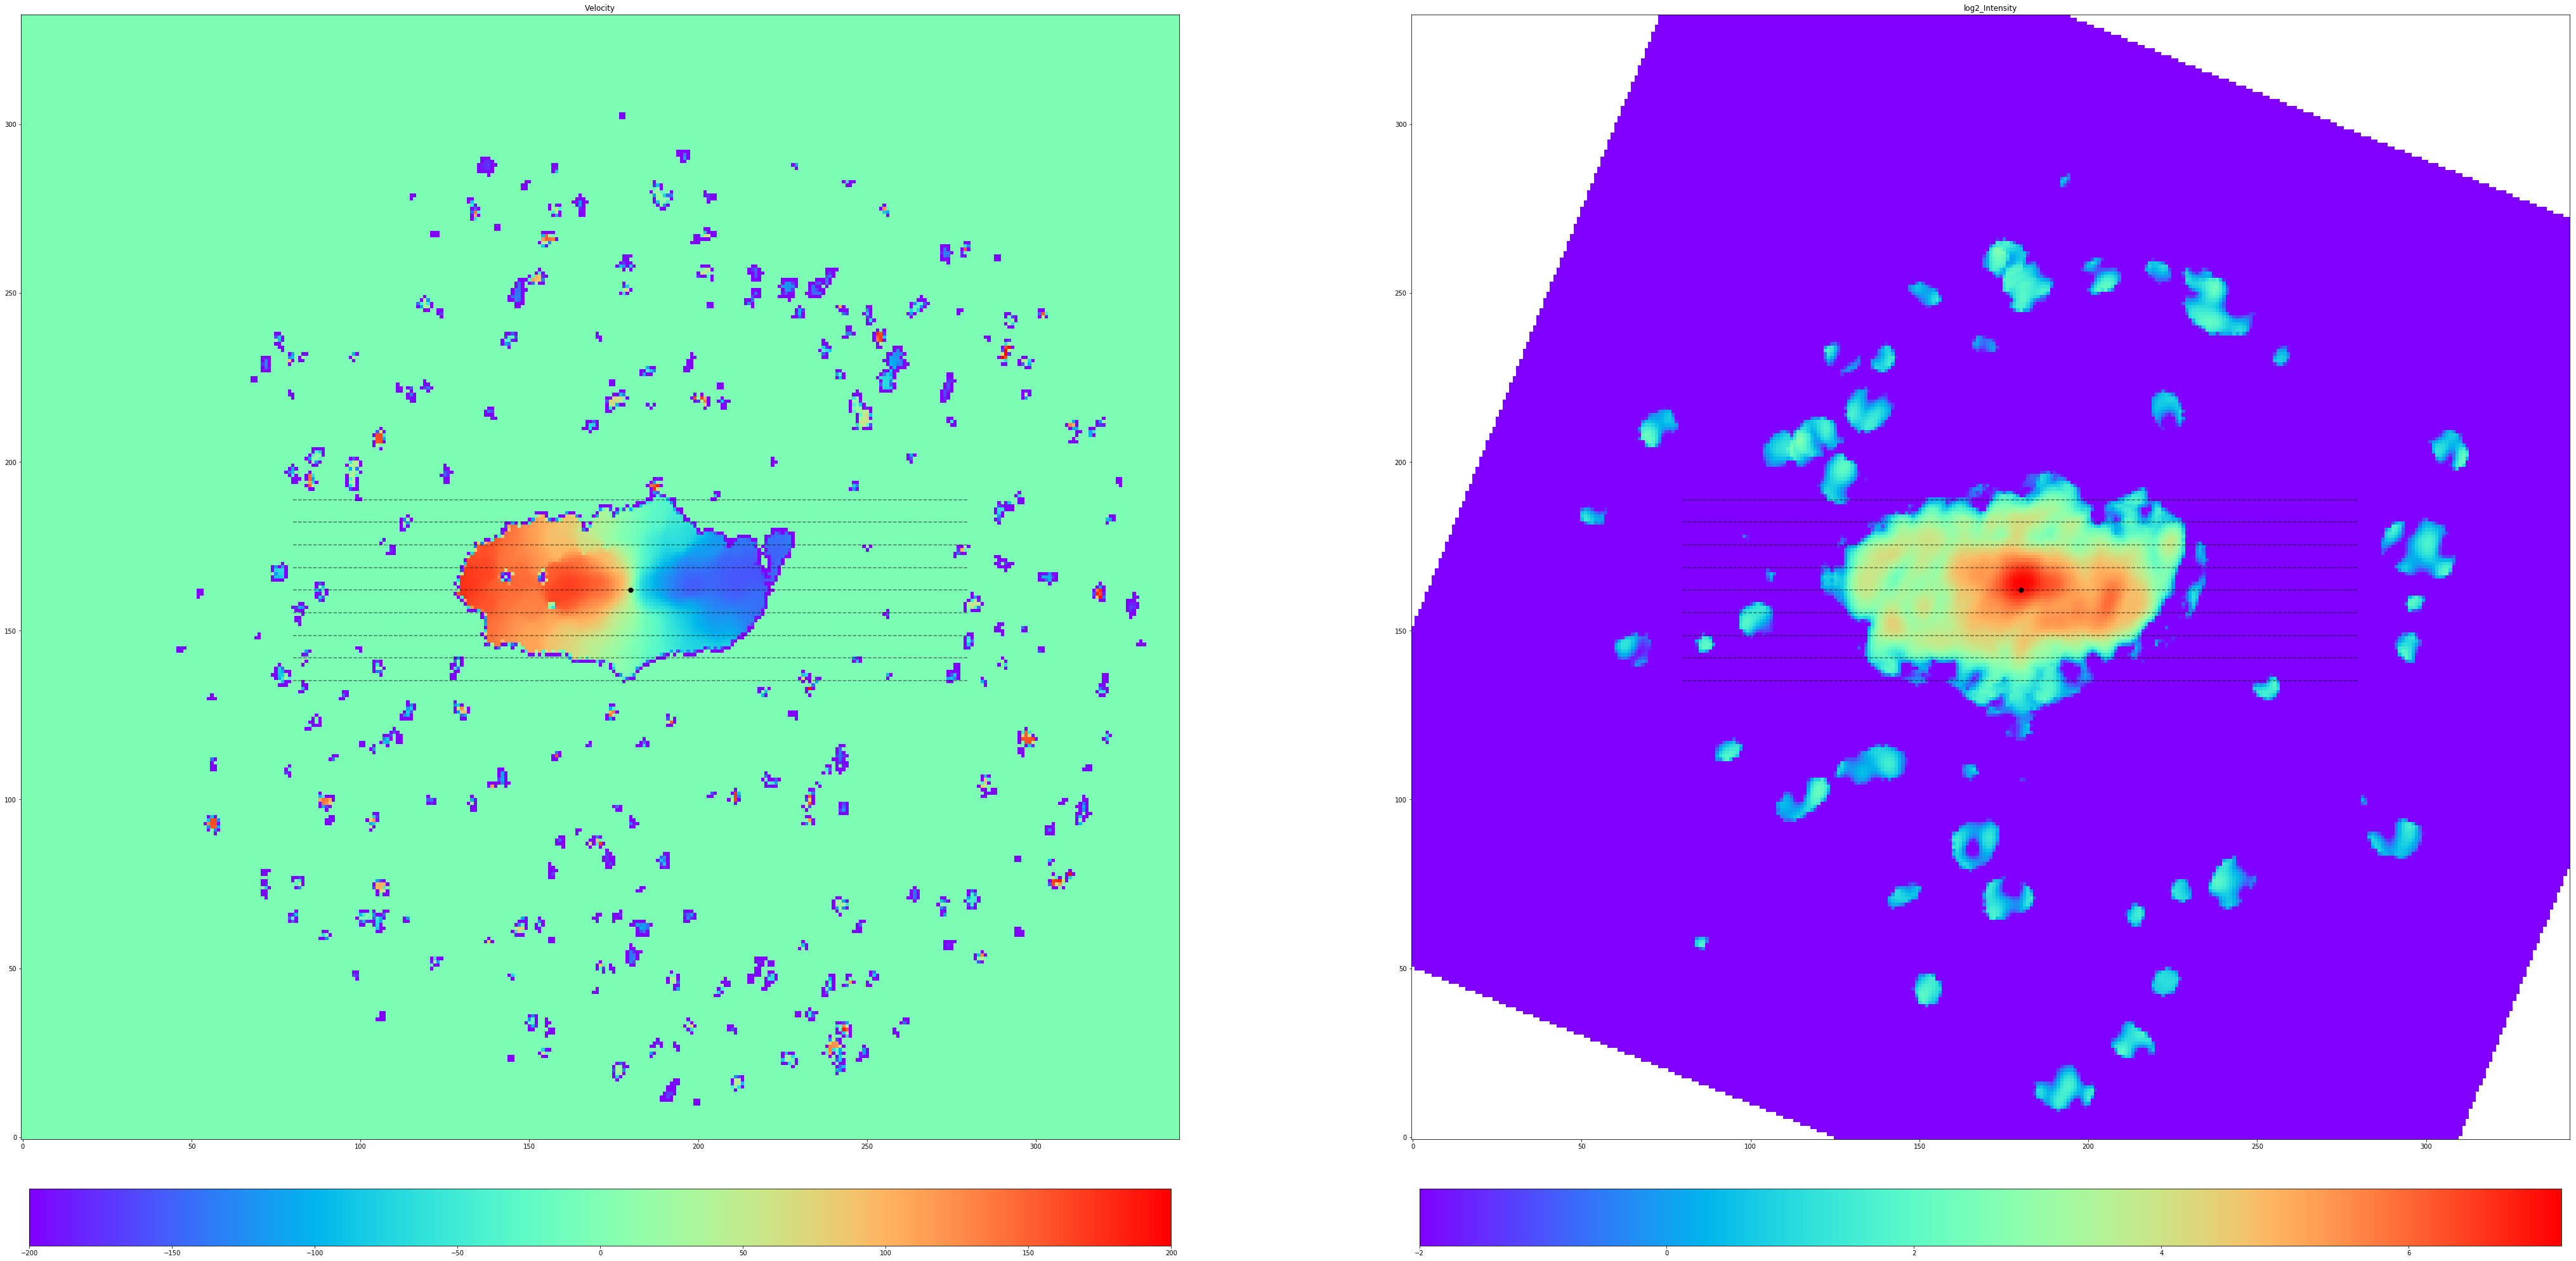

coefficient of determination R^2: 0.15358542617056392
intercept: -17.253+/-8.179 (SE)
slope Ω: -124.006+/-110.029 (SE)


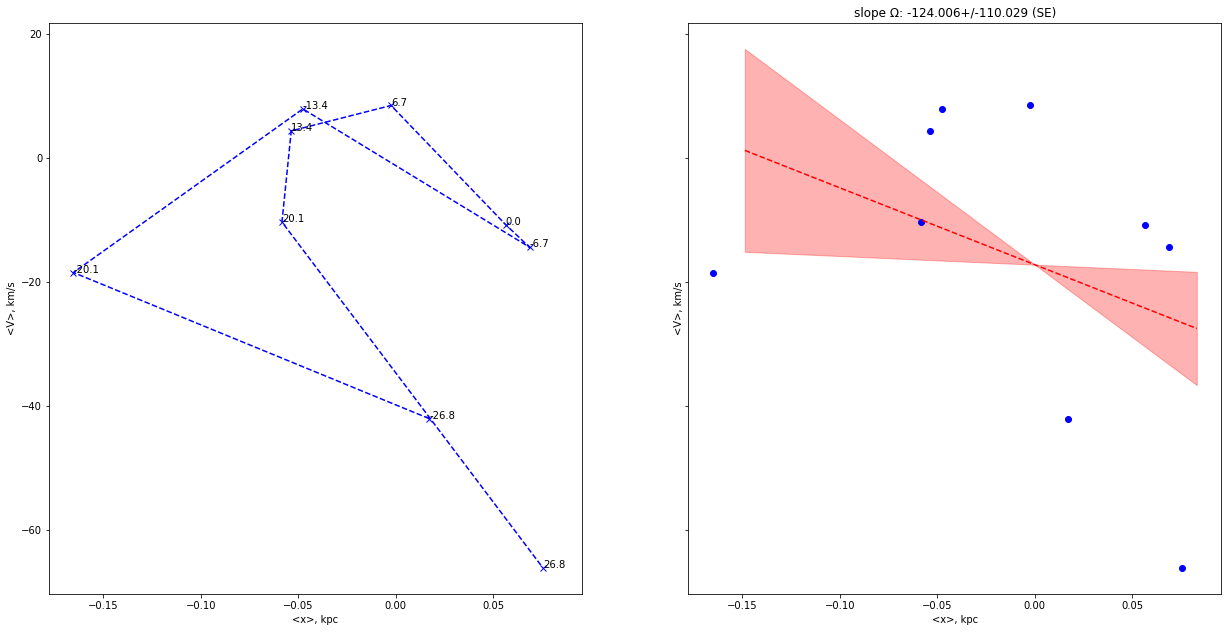

In [33]:
omega, omega_SE = pytwr.solve_TW(intens=plane_intens,
              vel=plane_v,
              center=image_center,
              incl=incl,
              ys = [],
              delta_y=6.7,
              y_bins=4,
              X_max=100.0,
              ymin=0.,
              verbose=True,
              r_scale=pix_kpc,
              ax=None,
              img_scale=1.5)

 We can compare this images with those from [https://arxiv.org/pdf/astro-ph/0406426.pdf] and with plot from TWR article:

# Appendix, WIP

**Do not look here, just unfinished experiments and raw code.**

In [9]:
def ell_line_inters(line_height, ell_height, cos_i, cen_x, cen_y):
    """
    Find two intersection points for line parallel X-axis and ellipsis
    :param line_height:
    :param ell_height:
    :param cos_i:
    :param cen_x:
    :param cen_y:
    :return:
    """
    yi = line_height
    yii = ell_height
    tmp = (yii / cos_i) ** 2 - (yi / cos_i) ** 2
    tmp = 0 if tmp < 1e-5 else tmp # TODO: why this is needed?
    right = [np.sqrt(tmp) + cen_x, yi + cen_y]
    left = [-np.sqrt(tmp) + cen_x, yi + cen_y]
    return (left, right)


def overlay_ellipses_grid(ax, ymin=None, delta_y=None, y_bins=None, X_max=None, center=None, incl=None):
    """
    Plot ellipses with step delta_y
    :param ax: image to plot on
    :param ymin: first ellipsis distance from center
    :param delta_y: ell width
    :param y_bins: number of ellipses
    :param X_max: tangent line boundary, from center
    :param center: (x,y) of center
    :param incl: inclination of galaxy
    """
    for ind_i in range(0, y_bins + 1, 1):
        cen_x,cen_y = center
        cos_i = np.cos(incl * np.pi / 180.)
        yi = ymin + ind_i * delta_y
        ax.plot([cen_x - X_max, cen_x + X_max], [cen_y + yi, cen_y + yi], '--', color='k', alpha=0.5)
        r0 = yi / cos_i
        x, y = generate_ell(r0,  incl)
        ax.plot(x + cen_x, y + cen_y, ':', color='k', alpha=0.5)


def plot_ifverbose_map(ax, map_data, title, lim_frame, ymin, delta_y, y_bins, X_max, cen_x, cen_y, **kwargs):
    """
    Plot data map.
    :param ax:
    :param map_data:
    :param title:
    :param lim_frame:
    :param ymin:
    :param delta_y:
    :param y_bins:
    :param X_max:
    :param cen_x:
    :param cen_y:
    :param kwargs:
    """
    im = ax.imshow(np.squeeze(map_data), origin='lower', **kwargs)
    if lim_frame:
        if ymin < 0 and delta_y < 0:
            ax.set_xlim(cen_x - X_max - 10, cen_x + X_max + 10)
            ax.set_ylim(cen_y + ymin + delta_y * y_bins - 10, cen_y + 5)
        else:
            ax.set_xlim(cen_x - X_max - 10, cen_x + X_max + 10)
            ax.set_ylim(cen_y - 5, cen_y + ymin + delta_y * y_bins + 10)
    plt.colorbar(im, fraction=0.046, pad=0.04, orientation="horizontal")
    ax.scatter(cen_x, cen_y, 50, 'k')
    ax.set_title(title)


def grid_point_val(points_grid, dmap=None, method='linear'):
    """
    This function takes 2d array and list of points and interpolate values to these points.
    :param points_grid: list of points to interpolate values into
    :param dmap: data map, 2d numpy array
    :param method: 'linear', 'nearest' or 'cubic'
    :return: list of interpolated values
    """
    xm, ym = np.meshgrid(np.arange(dmap.shape[1]), np.arange(dmap.shape[0]))
    return interp.griddata(list(zip(xm.ravel(), ym.ravel())), dmap.ravel(), points_grid, method=method)

def generate_ell(r, incl):
    phi = np.linspace(0, np.pi, 100)
    cos_i = np.cos(incl * np.pi / 180.)

    x = np.cos(phi) * r
    y = np.array([cos_i * np.sqrt(r ** 2 - x_ ** 2) for x_ in x])

    x_ = np.cos(phi) * r
    y_ = -np.array([cos_i * np.sqrt(r ** 2 - x_ ** 2) for x_ in x])
    return np.concatenate([x, x_[::-1]]), np.concatenate([y, y_[::-1]])


def gen_ell_point(r, y, incl):
    cos_i = np.cos(incl * np.pi / 180.)
    return np.sqrt(r ** 2 - y ** 2 / cos_i ** 2)

In [12]:
intens=plane_intens
vel=plane_v
center=image_center
incl=incl
delta_y = delta_y
y_bins = y_bins
ymin=ymin
X_max = X_max
verbose=True 
r_scale=pix_kpc
lim_frame=True
img_scale=1.5

/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log2
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log2


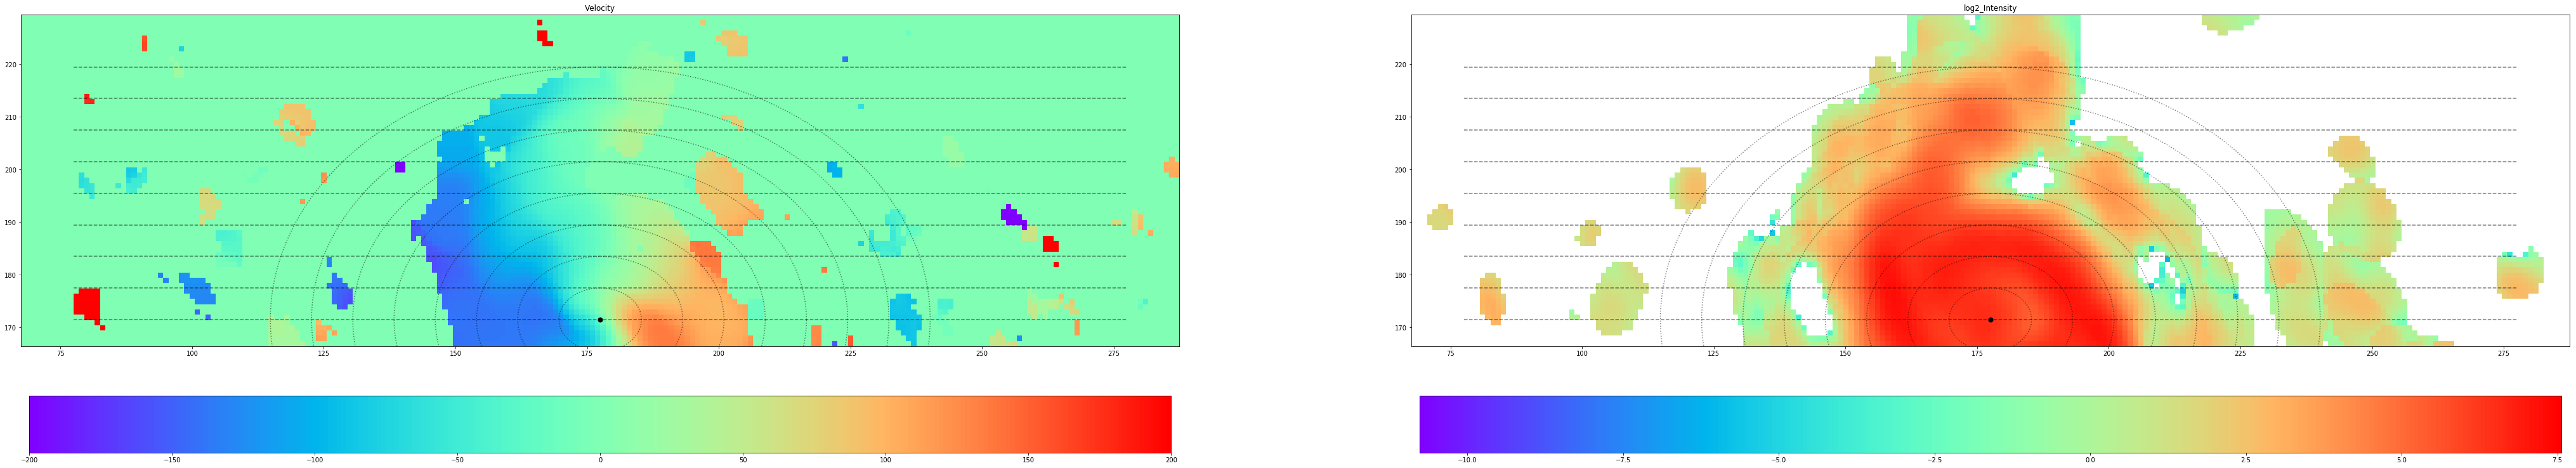

In [15]:
cen_x, cen_y = center

cos_i = np.cos(incl * np.pi / 180.)
sin_i = np.sin(incl * np.pi / 180.)

if ymin is None:
    ymin = delta_y

# plot velocity and intensity maps with superimposed ellipses
if verbose:
    fig = plt.figure(figsize=[48 * img_scale, 24 * img_scale])

    ax = plt.subplot(121)
    plot_ifverbose_map(ax, vel, 'Velocity', lim_frame, ymin, delta_y, y_bins, X_max, cen_x, cen_y, cmap='rainbow', vmin=-200, vmax=200)
    overlay_ellipses_grid(ax, ymin=ymin, delta_y=delta_y, y_bins=y_bins, X_max=X_max, center=center, incl=incl)

    ax = plt.subplot(122)
    plot_ifverbose_map(ax, np.log2(intens), 'log2_Intensity', lim_frame, ymin, delta_y, y_bins, X_max, cen_x, cen_y, cmap='rainbow')
    overlay_ellipses_grid(ax, ymin=ymin, delta_y=delta_y, y_bins=y_bins, X_max=X_max, center=center, incl=incl)

    plt.show()

In [16]:
from scipy.linalg import solve_triangular
import scipy.interpolate as interp
import numpy as np

In [17]:
delta_y = 6.
y_bins = 8
ymin=0.

right_side = np.zeros(y_bins)
left_side = np.zeros(y_bins)
intens_integral = np.zeros(y_bins)

# fill equations (triangular matrix)
for ind_i in range(0, y_bins, 1):
    yi = ymin + ind_i * delta_y
    
    full_slice_points = [(_ + cen_x + 0.5, yi + cen_y + 0.5) for _ in np.arange(-X_max, X_max, 1)]
    
    sigma_fsp = grid_point_val(full_slice_points, dmap=intens)
    vel_fsp = grid_point_val(full_slice_points, dmap=vel)
    right_side[ind_i] = np.sum(sigma_fsp * vel_fsp / sin_i)
    
    x_fsp = np.array([_[0]*r_scale for _ in full_slice_points]) - cen_x*r_scale
    left_side[ind_i] = np.sum(sigma_fsp * x_fsp)
    
    intens_integral[ind_i] = np.sum(sigma_fsp)

In [18]:
delta_y = -6.
y_bins = 8
ymin=0.

right_side_ = np.zeros(y_bins)
left_side_ = np.zeros(y_bins)
intens_integral_ = np.zeros(y_bins)

# fill equations (triangular matrix)
for ind_i in range(0, y_bins, 1):
    yi = ymin + ind_i * delta_y
    
    full_slice_points = [(_ + cen_x + 0.5, yi + cen_y + 0.5) for _ in np.arange(-X_max, X_max, 1)]
    
    sigma_fsp = grid_point_val(full_slice_points, dmap=intens)
    vel_fsp = grid_point_val(full_slice_points, dmap=vel)
    right_side_[ind_i] = np.sum(sigma_fsp * vel_fsp / sin_i)
    
    x_fsp = np.array([_[0]*r_scale for _ in full_slice_points]) - cen_x*r_scale
    left_side_[ind_i] = np.sum(sigma_fsp * x_fsp)
    
    intens_integral_[ind_i] = np.sum(sigma_fsp)

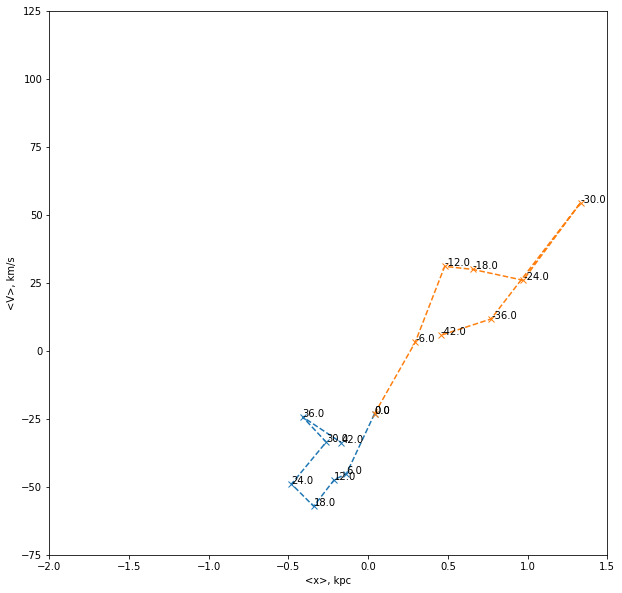

In [19]:
fig = plt.figure(figsize=[10,10])

# pts = []

# for ind_i in range(0, y_bins, 1):
#     sig_mean = intens_integral[ind_i]
# #     sig_mean = 1.
#     v_mean = right_side[ind_i]/sig_mean
#     x_mean = left_side[ind_i]/sig_mean
#     plt.scatter(x_mean, v_mean, 10)

xp,yp = np.array(left_side)/np.array(intens_integral), np.array(right_side)/np.array(intens_integral)
plt.plot(xp,yp, 'x--')

for ind_i in range(0, y_bins, 1):
    plt.annotate(str(ymin - ind_i * delta_y), (xp[ind_i], yp[ind_i]))

xp,yp = np.array(left_side_)/np.array(intens_integral_), np.array(right_side_)/np.array(intens_integral_)
plt.plot(xp,yp, 'x--')

for ind_i in range(0, y_bins, 1):
    plt.annotate(str(ymin + ind_i * delta_y), (xp[ind_i], yp[ind_i]))
    

plt.xlabel('<x>, kpc')
plt.ylabel('<V>, km/s')

plt.xlim(-2,1.5)
plt.ylim(-75,125)

plt.show()

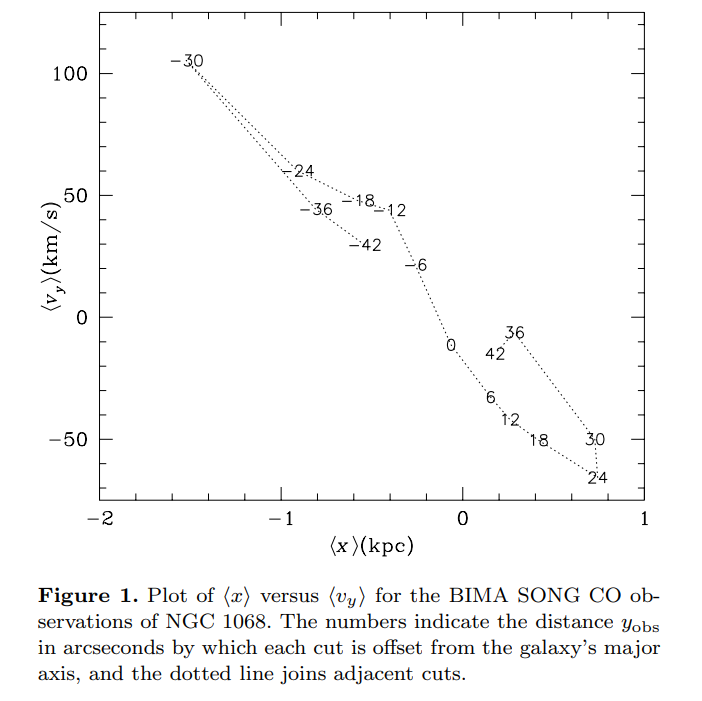

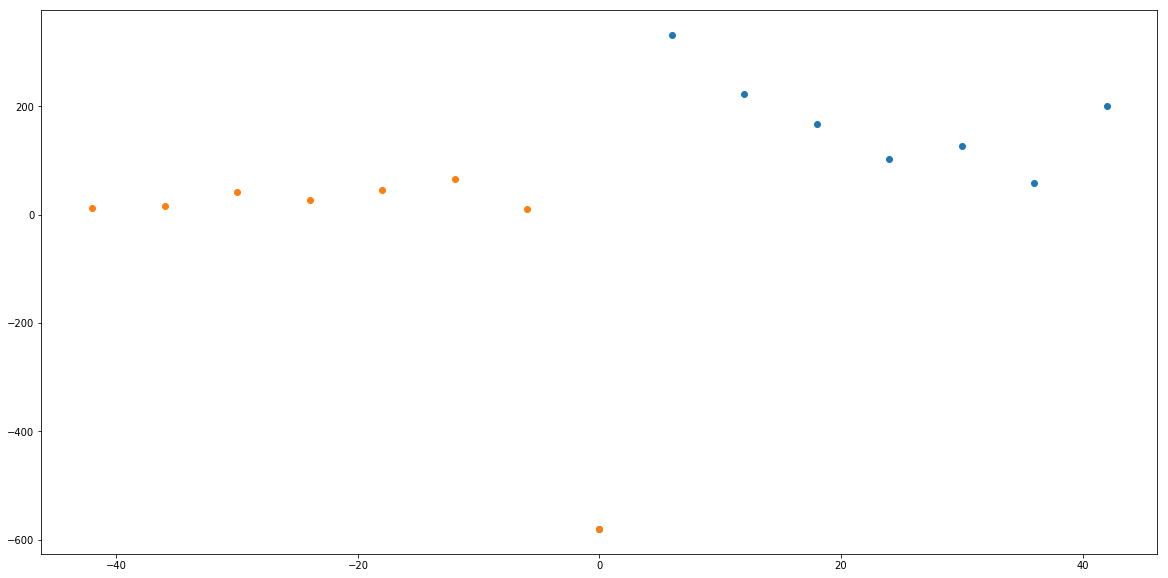

In [21]:
fig = plt.figure(figsize=[20,10])

xp,yp = [ymin - _ * delta_y for _ in range(0, y_bins, 1)], np.array(right_side)/np.array(left_side)
plt.plot(xp,yp, 'o')

xp,yp = [ymin + _ * delta_y for _ in range(0, y_bins, 1)], np.array(right_side_)/np.array(left_side_)
plt.plot(xp,yp, 'o')  

# plt.xlabel('<x>, kpc')
# plt.ylabel('<V>, km/s')

# plt.xlim(-2,1.5)
# plt.ylim(0,125)

plt.show()

In [22]:
from sklearn.linear_model import LinearRegression

coefficient of determination: 0.8738736832952009
intercept: -22.110660091542563
slope: [59.38568072]


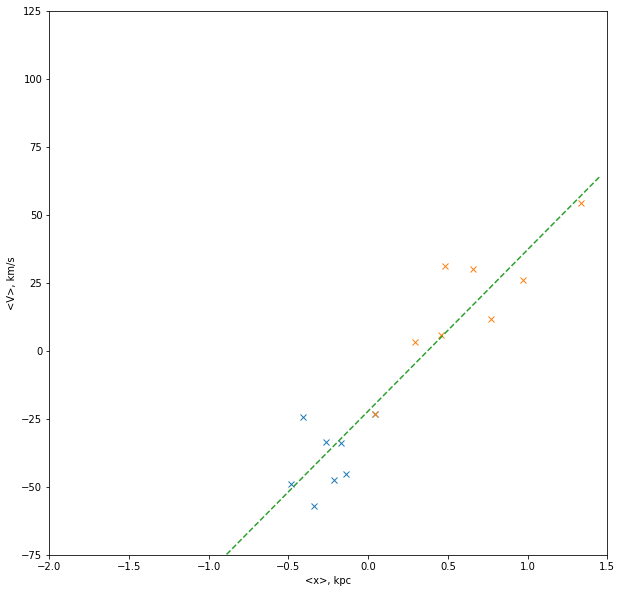

In [26]:
fig = plt.figure(figsize=[10,10])

xp,yp = np.array(left_side)/np.array(intens_integral), np.array(right_side)/np.array(intens_integral)
plt.plot(xp,yp, 'x')

# for ind_i in range(0, y_bins, 1):
#     plt.annotate(str(ymin - ind_i * delta_y), (xp[ind_i], yp[ind_i]))

xp_,yp_ = np.array(left_side_)/np.array(intens_integral_), np.array(right_side_)/np.array(intens_integral_)
plt.plot(xp_,yp_, 'x')

# for ind_i in range(0, y_bins, 1):
#     plt.annotate(str(ymin + ind_i * delta_y), (xp[ind_i], yp[ind_i]))


x = np.concatenate([np.array(xp), np.array(xp_)]).reshape((-1, 1))
y = np.concatenate([np.array(yp), np.array(yp_)])
model = LinearRegression().fit(x, y)


r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)

print('intercept:', model.intercept_)
print('slope:', model.coef_)

y_pred = model.predict(np.arange(-2, 1.5, 0.05).reshape((-1, 1)))


plt.plot(np.arange(-2, 1.5, 0.05), y_pred, '--')



plt.xlabel('<x>, kpc')
plt.ylabel('<V>, km/s')

plt.xlim(-2,1.5)
plt.ylim(-75,125)

plt.show()

In [31]:
import statsmodels.api as sm
x = sm.add_constant(x)
ols = sm.OLS(y, x)
ols_result = ols.fit()
# Now you have at your disposition several error estimates, e.g.
print(ols_result.HC0_se)
# and covariance estimates
print(ols_result.cov_HC0)

[3.22449746 5.0968809 ]
[[10.39738384 -6.90865533]
 [-6.90865533 25.97819496]]


In [32]:
ols_result.params

array([-22.11066009,  59.38568072])

In [34]:
print(ols_result.bse)
print(ols_result.rsquared)

[3.35557863 6.02970753]
0.8738736832952009


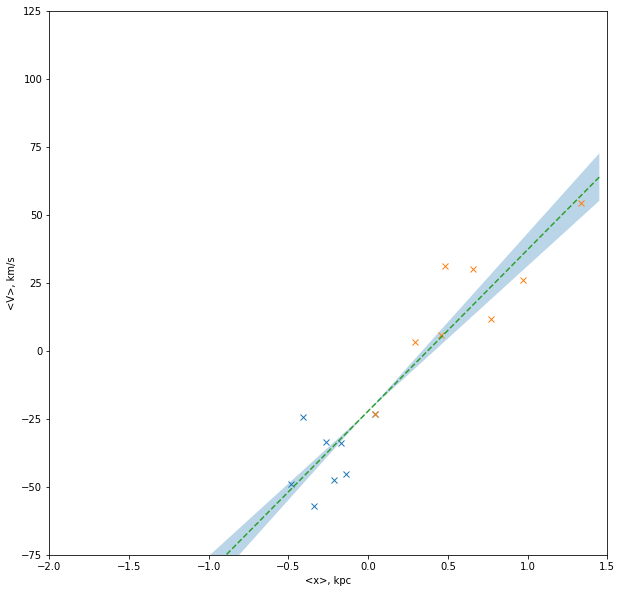

In [38]:
fig = plt.figure(figsize=[10,10])

xp,yp = np.array(left_side)/np.array(intens_integral), np.array(right_side)/np.array(intens_integral)
plt.plot(xp,yp, 'x')

xp_,yp_ = np.array(left_side_)/np.array(intens_integral_), np.array(right_side_)/np.array(intens_integral_)
plt.plot(xp_,yp_, 'x')

x = np.concatenate([np.array(xp), np.array(xp_)]).reshape((-1, 1))
y = np.concatenate([np.array(yp), np.array(yp_)])


def linm(slope, intercept, xvals):
    return slope*xvals + intercept


y_pred = linm(ols_result.params[1], ols_result.params[0], np.arange(-2, 1.5, 0.05))
plt.plot(np.arange(-2, 1.5, 0.05), y_pred, '--')

y_pred_max = linm(ols_result.params[1]-ols_result.bse[1], ols_result.params[0], np.arange(-2, 1.5, 0.05))
y_pred_min = linm(ols_result.params[1]+ols_result.bse[1], ols_result.params[0], np.arange(-2, 1.5, 0.05))
plt.fill_between(np.arange(-2, 1.5, 0.05), y_pred_max, y_pred_min, alpha=0.3)


plt.xlabel('<x>, kpc')
plt.ylabel('<V>, km/s')

plt.xlim(-2,1.5)
plt.ylim(-75,125)

plt.show()

In [44]:
right_side = np.zeros(y_bins)
left_side = np.zeros(y_bins)
intens_integral = np.zeros(y_bins)

for ind_i in range(0, y_bins, 1):
    yi = ymin + ind_i * delta_y
    
    int_slice = int(cen_y + yi + 1)
    xmi,xma = int(cen_x - X_max - 1), int(cen_x + X_max + 1)
    xrange = range(xmi,xma, 1)

    vdata = np.ravel(vel[int_slice, xmi:xma])
    idata = np.ravel(intens[int_slice, xmi:xma])
    
    
    right_side[ind_i] = np.sum(idata * vdata / sin_i)
    
    x_fsp = (np.array(xrange) - cen_x)*r_scale
    left_side[ind_i] = np.sum(idata * x_fsp)
    
    intens_integral[ind_i] = np.sum(idata)

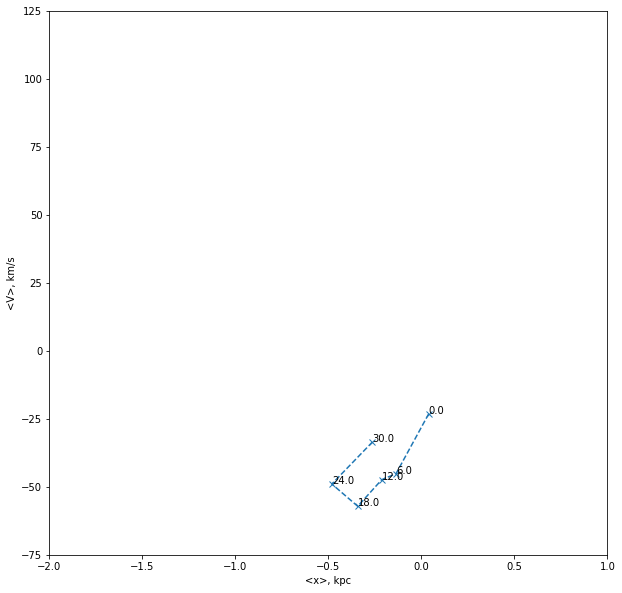

In [46]:
fig = plt.figure(figsize=[10,10])

# pts = []

# for ind_i in range(0, y_bins, 1):
#     sig_mean = intens_integral[ind_i]
# #     sig_mean = 1.
#     v_mean = right_side[ind_i]/sig_mean
#     x_mean = left_side[ind_i]/sig_mean
#     plt.scatter(x_mean, v_mean, 10)

xp,yp = np.array(left_side)/np.array(intens_integral), np.array(right_side)/np.array(intens_integral)
plt.plot(xp,yp, 'x--')

for ind_i in range(0, y_bins, 1):
    plt.annotate(str(ymin + ind_i * delta_y), (xp[ind_i], yp[ind_i]))


plt.xlabel('<x>, kpc')
plt.ylabel('<V>, km/s')

plt.xlim(-2,1)
plt.ylim(-75,125)

plt.show()

In [45]:
def solve_TW(intens=None,
              vel=None,
              center=None,
              incl=None,
              ys = [],
              delta_y=15.,
              y_bins=4,
              X_max=None,
              ymin=0.,
              verbose=False,
              r_scale=1.,
              ax=None,
              img_scale=1.5):

    cen_x, cen_y = center

    cos_i = np.cos(incl * np.pi / 180.)
    sin_i = np.sin(incl * np.pi / 180.)

    if len(ys) == 0:
        ys = [ymin+_*delta_y for _ in range(-y_bins, y_bins+1, 1)]

    cen_x, cen_y = center

    cos_i = np.cos(incl * np.pi / 180.)
    sin_i = np.sin(incl * np.pi / 180.)

    if ymin is None:
        ymin = delta_y

    # plot velocity and intensity maps along with apertures
    if verbose:
        fig = plt.figure(figsize=[48 * img_scale, 24 * img_scale])

        ax = plt.subplot(121)
        plot_ifverbose_map(ax, vel, 'Velocity', False, ymin, delta_y, y_bins, X_max, cen_x, cen_y, cmap='rainbow',
                           vmin=-200, vmax=200)

        for yi in ys:
            ax.plot([cen_x - X_max, cen_x + X_max], [cen_y + yi, cen_y + yi], '--', color='k', alpha=0.5)

        ax = plt.subplot(122)
        plot_ifverbose_map(ax, np.log2(intens), 'log2_Intensity', False, ymin, delta_y, y_bins, X_max, cen_x, cen_y,
                           cmap='rainbow')

        for yi in ys:
            ax.plot([cen_x - X_max, cen_x + X_max], [cen_y + yi, cen_y + yi], '--', color='k', alpha=0.5)

        plt.show()

    right_side = np.zeros(len(ys))
    left_side = np.zeros(len(ys))
    intens_integral = np.zeros(len(ys))
        
    print(len(ys))
    
    # fill equations right and left side
    for ind_i, yi in enumerate(ys):
        full_slice_points = [(_ + cen_x + 0.5, yi + cen_y + 0.5) for _ in np.arange(-X_max, X_max, 1)]

        sigma_fsp = grid_point_val(full_slice_points, dmap=intens)
        vel_fsp = grid_point_val(full_slice_points, dmap=vel)
        right_side[ind_i] = np.sum(sigma_fsp * vel_fsp / sin_i)

        x_fsp = np.array([_[0] * r_scale for _ in full_slice_points]) - cen_x * r_scale
        left_side[ind_i] = np.sum(sigma_fsp * x_fsp)

        intens_integral[ind_i] = np.sum(sigma_fsp)



    # calculate <x> and <v_y> values weighted by intensity integral
    xp, yp = np.array(left_side) / np.array(intens_integral), np.array(right_side) / np.array(intens_integral)
    
    print(xp)
    print(yp)
    
    # build model
    x = sm.add_constant(xp.reshape((-1, 1)))
    ols = sm.OLS(yp, x)
    ols_result = ols.fit()

    if verbose:

        r_sq = ols_result.rsquared
        print('coefficient of determination R^2:', r_sq)
        print('intercept: {:.3f}+/-{:.3f} (SE)'.format(ols_result.params[0], ols_result.bse[0]))
        print('slope Ω: {:.3f}+/-{:.3f} (SE)'.format(ols_result.params[1], ols_result.bse[1]))

        fig = plt.figure(figsize=[48 * img_scale, 24 * img_scale])

        ax = plt.subplot(121)
        ax.plot(xp, yp, 'x--', color='b')
        for ind_i, yi in enumerate(ys):
            plt.annotate(str(yi), (xp[ind_i], yp[ind_i]))

        ax = plt.subplot(122)
        ax.plot(xp, yp, 'o', color='b')

        def linm(slope, intercept, xvals):
            return slope * xvals + intercept

        pps = np.linspace(min(xp)*0.9, max(xp)*1.1, 100)

        y_pred = linm(ols_result.params[1], ols_result.params[0], pps)
        plt.plot(pps, y_pred, '--', color='r')

        y_pred_max = linm(ols_result.params[1] - ols_result.bse[1], ols_result.params[0], pps)
        y_pred_min = linm(ols_result.params[1] + ols_result.bse[1], ols_result.params[0], pps)
        plt.fill_between(pps, y_pred_max, y_pred_min, alpha=0.3, color='r')

        plt.title('slope Ω: {:.3f}+/-{:.3f} (SE)'.format(ols_result.params[1], ols_result.bse[1]))

        plt.xlabel('<x>, kpc')
        plt.ylabel('<V>, km/s')

        plt.show()
    
    omega, omega_se = ols_result.params[1], ols_result.bse[1]
    
    return omega, omega_se

/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log2
/mnt/sdb2/upwork/anton/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log2


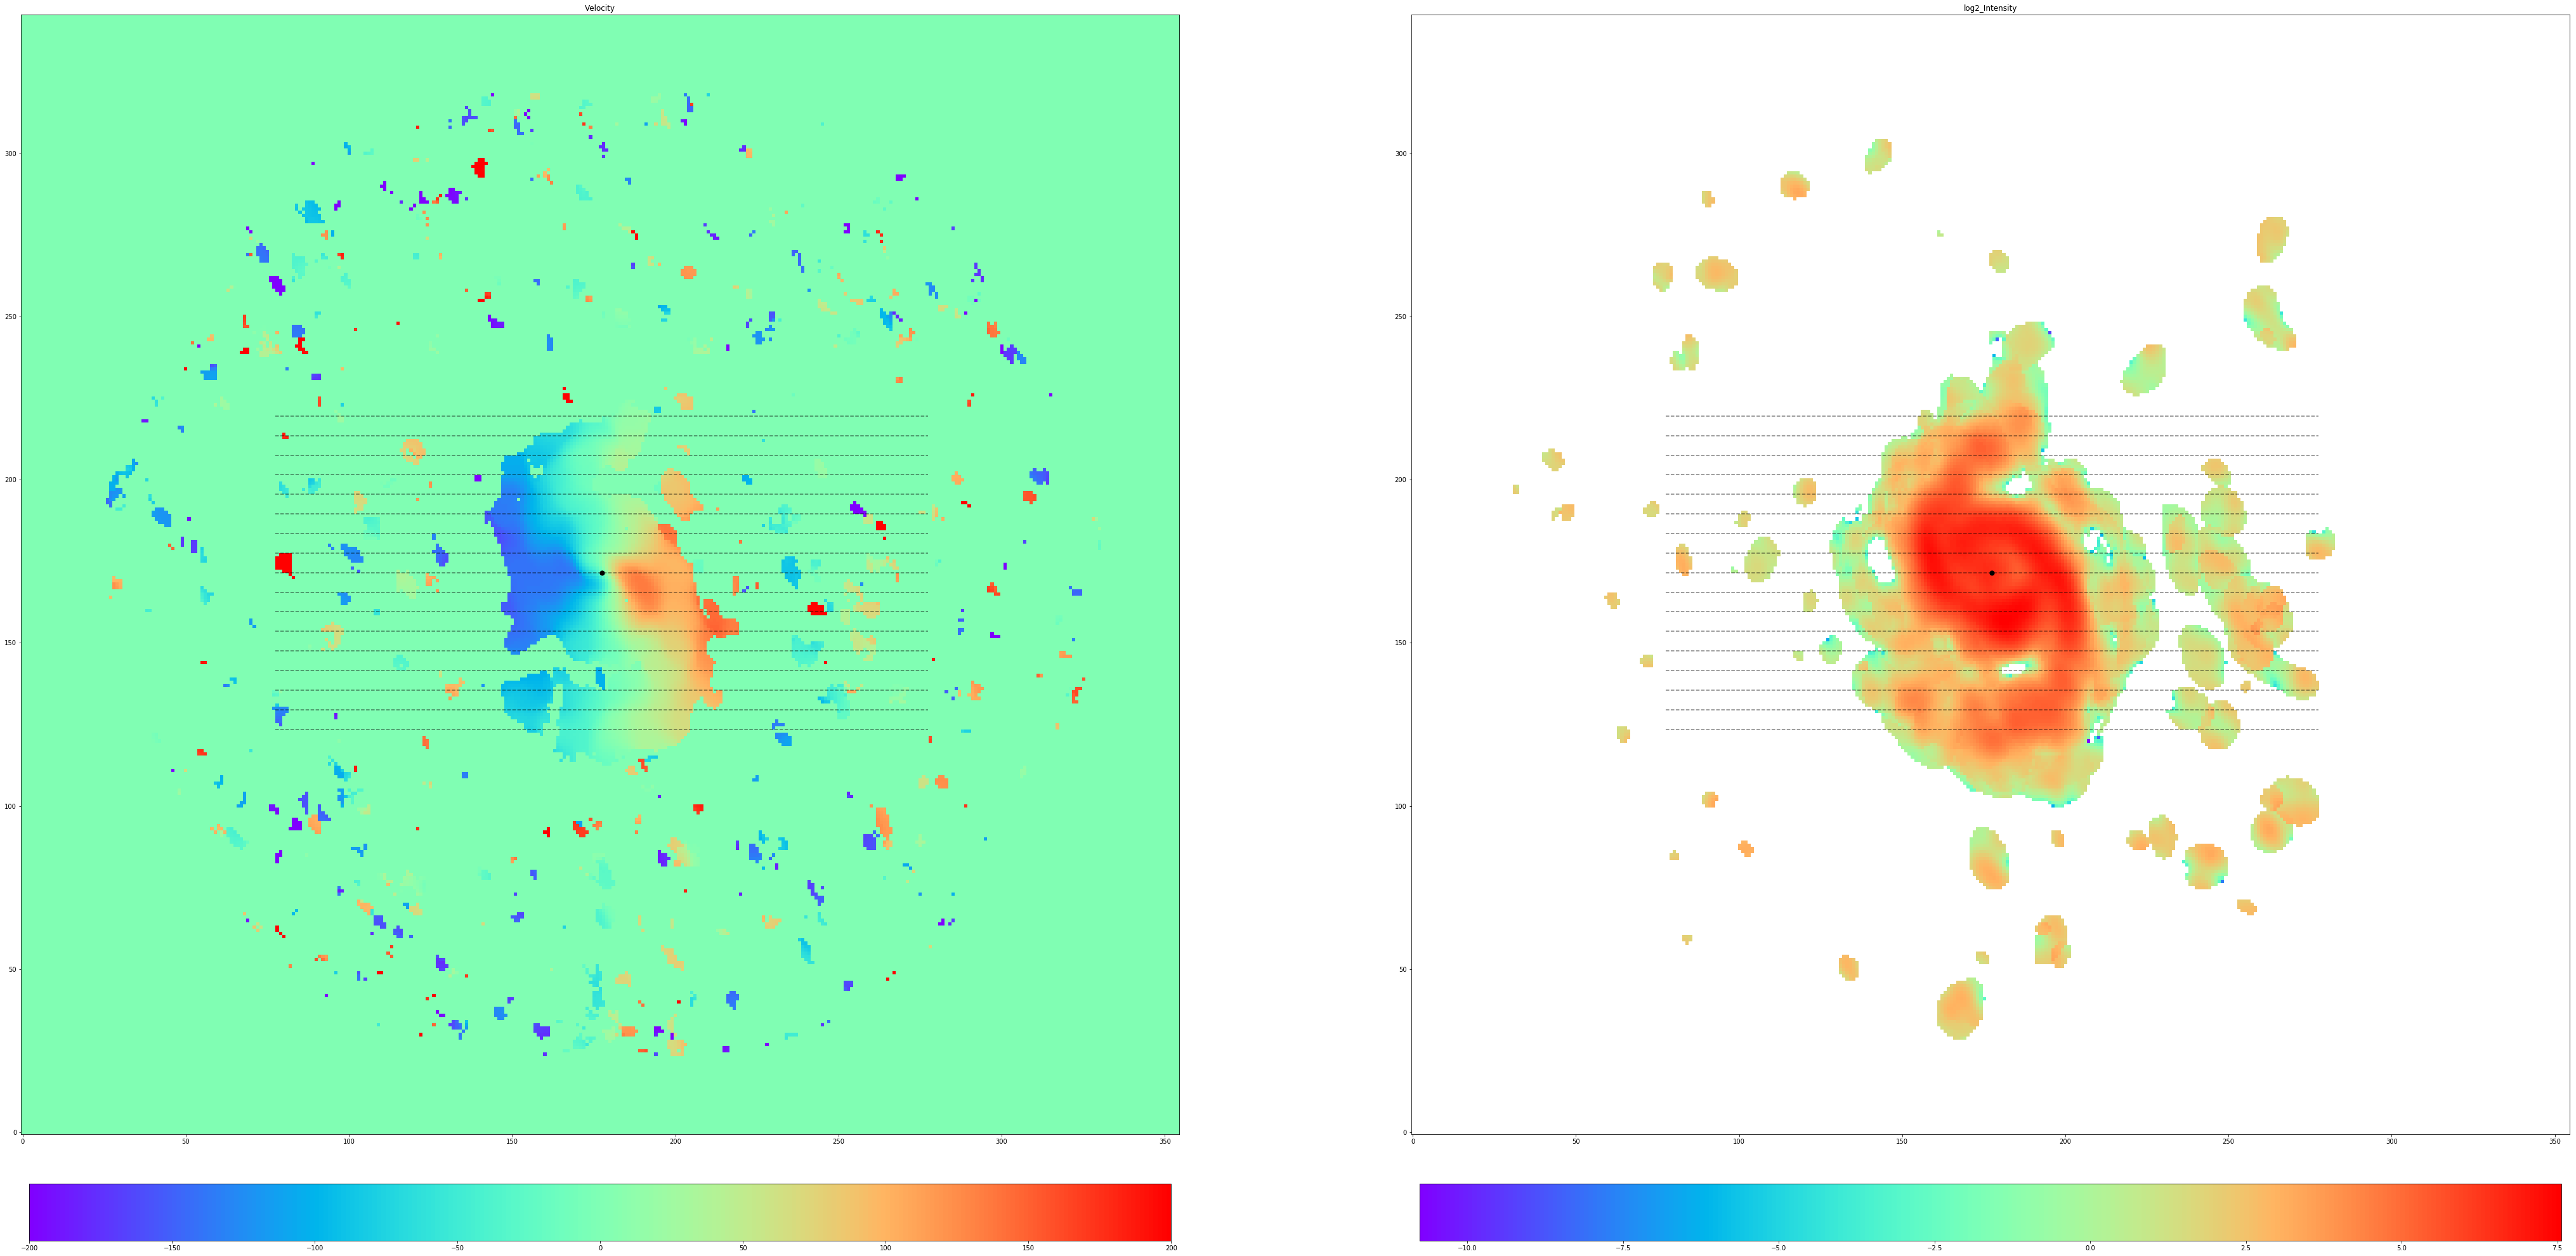

17
[ 0.48678947  0.45613936  0.77074329  1.33310791  0.97233189  0.65641297
  0.47967753  0.29518141  0.03980493 -0.13617058 -0.21307154 -0.34189438
 -0.48112683 -0.26336158 -0.41164176 -0.16764325  0.18787053]
[ 17.88453657   5.76652704  11.7706663   54.59497117  26.01671359
  30.00278714  31.11367924   3.20924977 -23.11763478 -45.16780968
 -47.38730749 -57.14766641 -48.95321065 -33.53338514 -24.24028218
 -33.74290726  12.38461396]
coefficient of determination R^2: 0.84983473192284
intercept: -19.973+/-3.598 (SE)
slope Ω: 59.785+/-6.489 (SE)


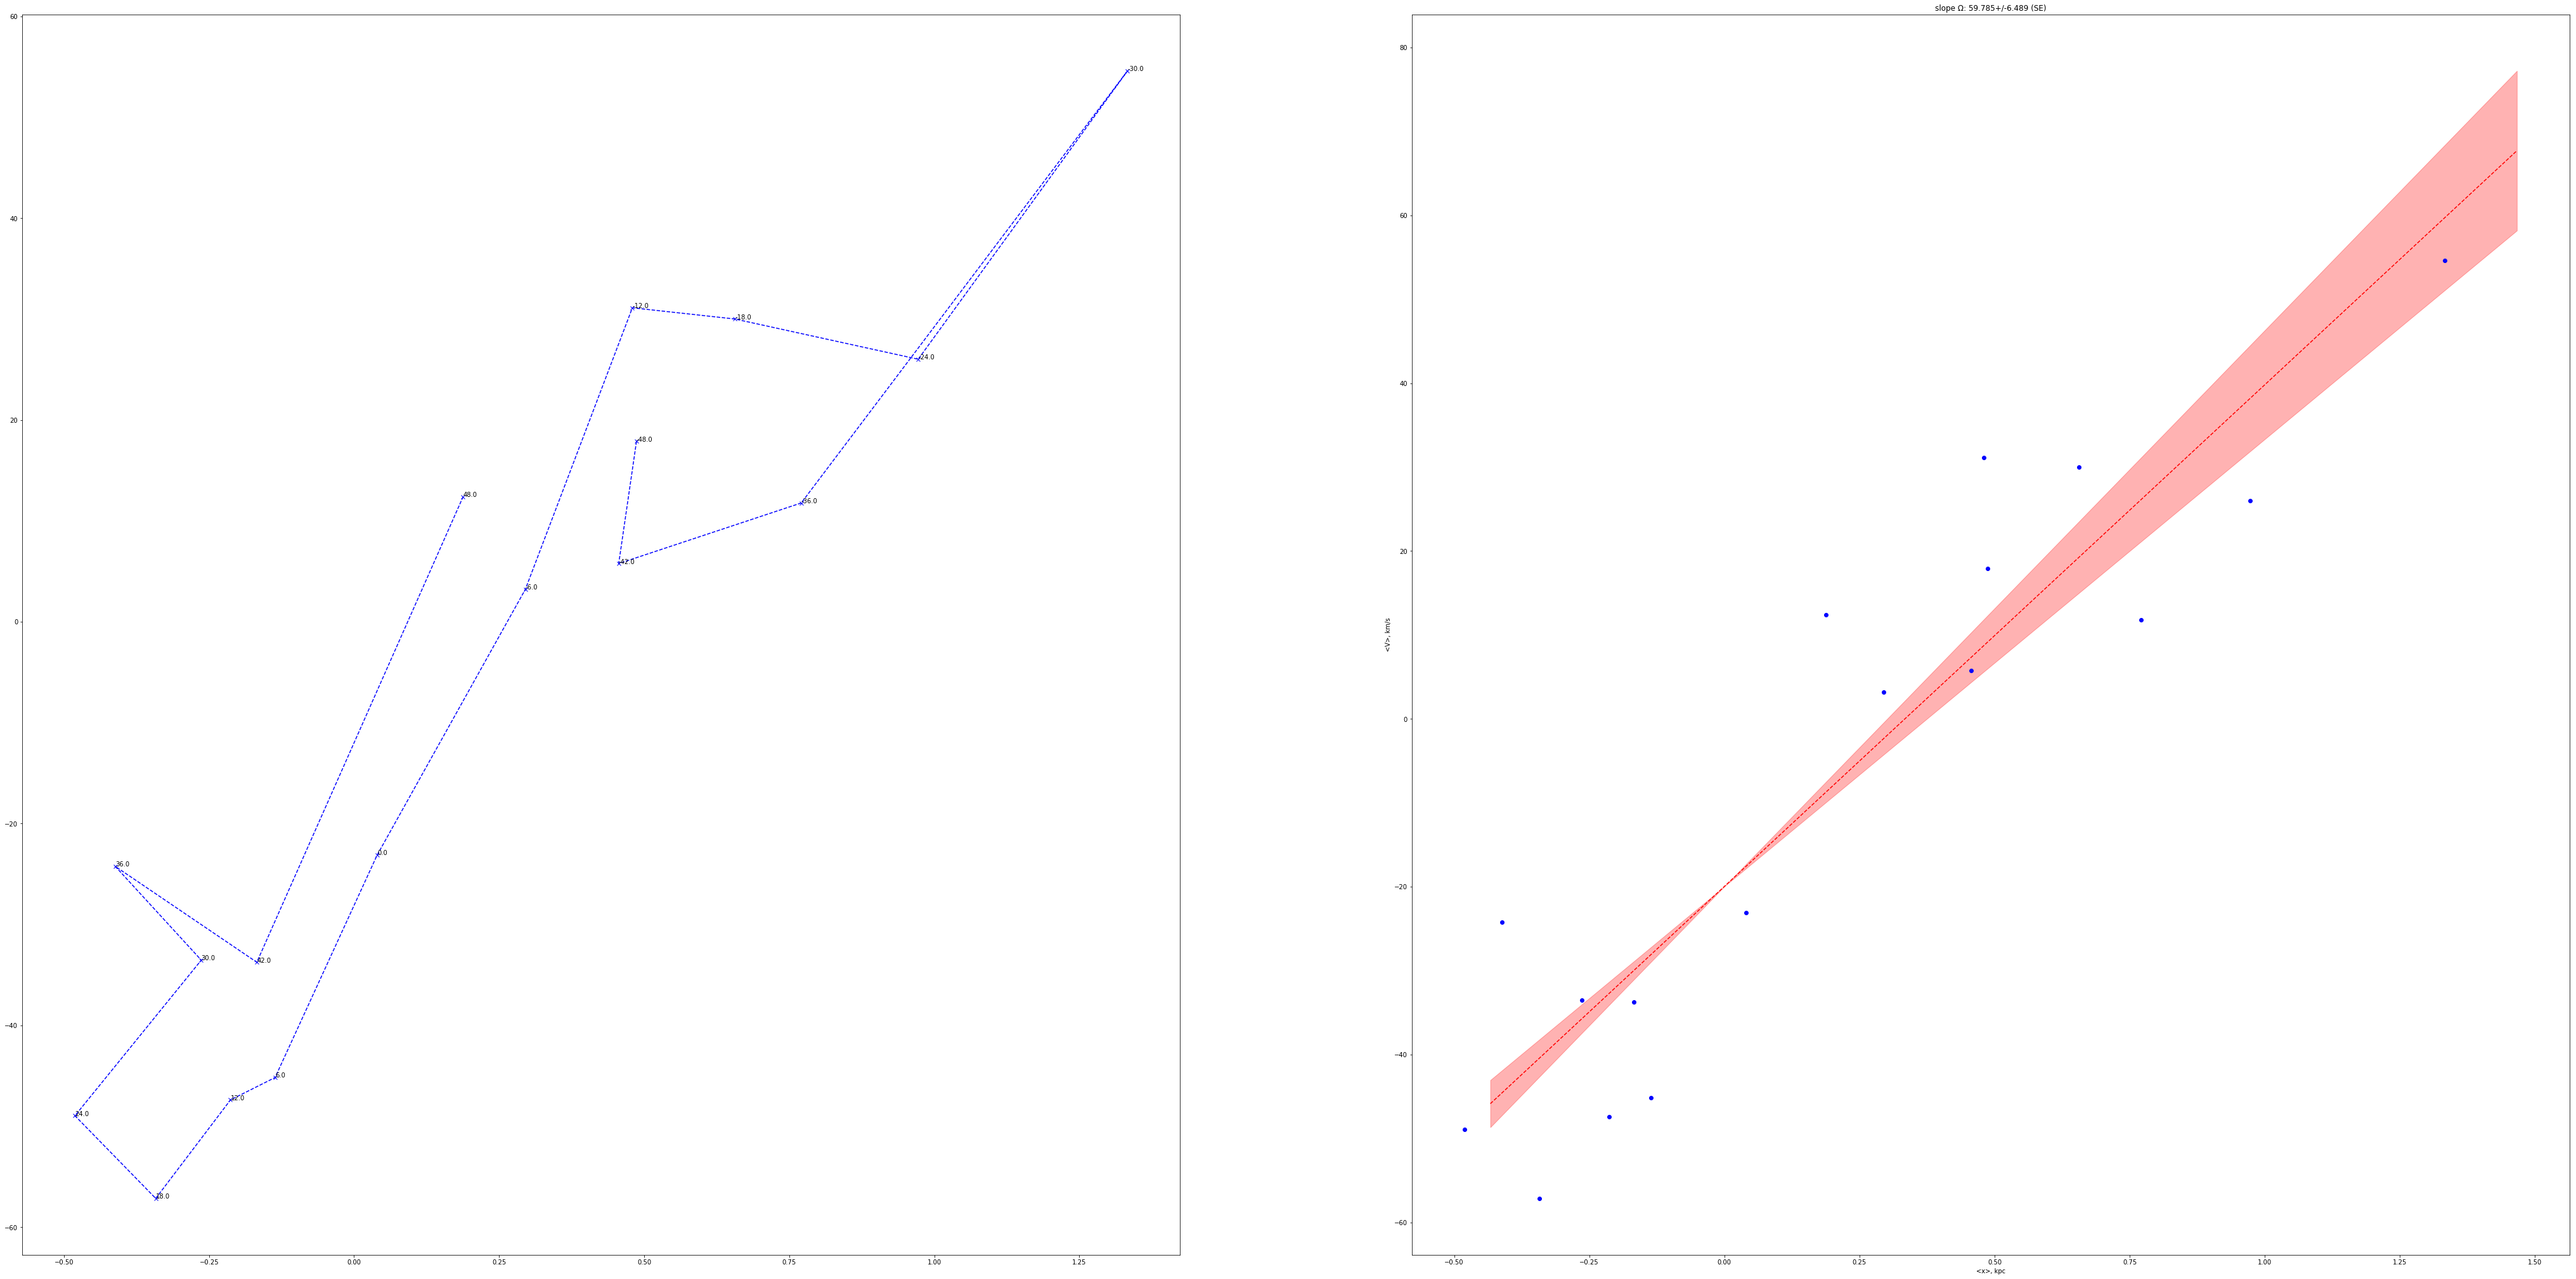

(59.78496945390751, 6.488792581473689)

In [46]:
solve_TW(intens=intens,
              vel=vel,
              center=center,
              incl=incl,
              ys = [],
              delta_y=6.,
              y_bins=8,
              X_max=X_max,
              ymin=0.,
              verbose=True,
              r_scale=pix_kpc,
              ax=None,
              img_scale=1.5)